### Pretraining Oracle
It is important that we pretrain the critic network before we dive deep into training the actor itself. Let's do exactly that

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import json
import h5py

f = h5py.File("/media/dev/New Volume/projects/RecNN/static_dataset.hdf5", "r")
cuda = torch.device('cuda')

frame_size = 10 

## WIP!

In [2]:
class StateRepresentation(nn.Module):
    def __init__(self):
        super(StateRepresentation, self).__init__()
        self.lin = nn.Sequential(
            # 128 - embed size, 1 - rating size
            nn.Linear(frame_size * (128 + 1), 256),
            nn.Tanh(),
        )
        
    def forward(self, state):
        # apply state represemtation module
        state = self.lin(state)
        return state

In [3]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.state_rep = StateRepresentation().to(cuda)
        
        # self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear1 = nn.Linear(256 + 128, hidden_size) #state rep + action + rating
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, enc_state, action):
        x = torch.cat([enc_state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [4]:
value_net  = Critic(256, 128, 320).to(cuda)
target_value_net  = Critic(256, 128, 320).to(cuda)
for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

value_lr  = 10e-5
value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
value_criterion = nn.MSELoss()

In [ ]:
def value_update(batch, 
           gamma = 0.99,
           min_value=-5,
           max_value=5,
           soft_tau=1e-2):
    
    state, action, reward, _, _ = batch

    enc_state = value_net.state_rep(state)
    value = value_net(enc_state, action)
    value_loss = value_criterion(value, reward)
    
    T_loss = torch.tensor(0)
    
    # you can uncomment these lines and see how the target network learns
    # it will work 2 times slower tho
    # T_enc_state = target_value_net.state_rep(*state)
    # T_value = target_value_net(enc_state, action)
    # T_loss = value_criterion(T_value, reward)
    
    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    losses = [value_loss.item(), T_loss.item()] 
    return losses

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def plot(losses, T_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('loss')
    plt.plot(losses, '-b')
    plt.plot(T_losses, '-w')
    plt.show()

In [ ]:
losses = []
T_losses = []

n_epochs = 3
batch_size = 5000
n_batches = (f['state'].shape[0] // batch_size) + 1

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

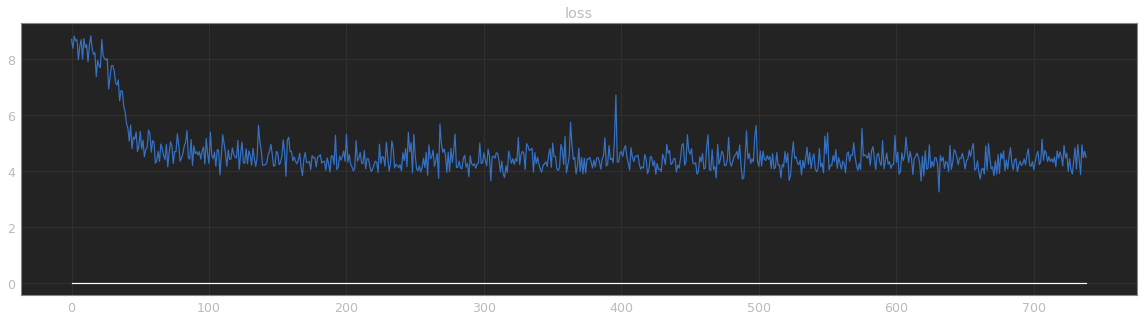

In [ ]:
def prepare_batch(*args):
    args = [torch.tensor(np.array(arg).astype(np.float)).to(cuda).float() for arg in args]
    return args

batch = []
for epoch in range(4):
    epoch_bar.update(1)
    for i in range(n_batches):
        batch_bar.update(1)
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
        batch = prepare_batch(*batch)
        loss = value_update(batch)
        losses.append(loss[0])
        T_losses.append(loss[1])
        
        batch = []
        
    batch_bar.refresh()    
    plot(losses, T_losses)

In [ ]:
dum_state = torch.tensor([[ 0.8234, -0.9226, -0.4121, -0.5340, -0.8833,  0.7875,  0.6483,  0.9270,
         0.7166,  0.3647, -0.6192,  0.4958,  0.2272,  0.5348,  0.8607, -0.8804,
        -0.2465, -0.4283, -0.4022,  0.1800,  0.5892,  0.3719, -0.8434,  0.8415,
         0.2611, -0.3241,  0.9081, -0.8466, -0.9381,  0.5714,  0.8995, -0.7719,
        -0.8924, -0.8616,  0.6031,  0.5534, -0.9667,  0.7193,  0.5872, -0.5237,
        -0.8892, -0.2707, -0.0501,  0.0757,  0.7951,  0.9076, -0.4727, -0.8728,
        -0.6557,  0.5244, -0.8006, -0.8477, -0.8758,  0.1813, -0.8301,  0.8902,
         0.0885,  0.9561, -0.4246, -0.5680,  0.3708, -0.2754, -0.1325, -0.8910,
         0.9343, -0.5149, -0.1698,  0.4403, -0.8597,  0.2069, -0.0524,  0.9302,
         0.0121,  0.0965,  0.0442,  0.9579,  0.9277, -0.7446,  0.8137, -0.9641,
         0.7567, -0.8799,  0.3058, -0.3211,  0.4471, -0.6690,  0.8665,  0.8037,
        -0.1293, -0.2239,  0.7319,  0.4257,  0.4706, -0.4224, -0.9544, -0.9011,
        -0.3293,  0.7725,  0.3611, -0.7188, -0.6263,  0.1799,  0.6883, -0.1732,
        -0.6490,  0.2394,  0.8581, -0.4586,  0.2242, -0.0524,  0.6026,  0.5842,
        -0.7486,  0.0851, -0.8351,  0.8072, -0.5694,  0.3146, -0.4573,  0.5108,
         0.7644, -0.8456,  0.7863,  0.4402, -0.1834, -0.2558, -0.2851,  0.9048,
        -0.8460, -0.8722,  0.8794,  0.5680, -0.8479, -0.9500, -0.9752, -0.9044,
         0.6765, -0.0330, -0.5040, -0.1801, -0.8043,  0.7728,  0.3033,  0.9752,
        -0.4627,  0.2142,  0.4854,  0.5244, -0.9714,  0.7670, -0.9627, -0.2361,
        -0.6224,  0.6705, -0.8673, -0.6650,  0.4627, -0.8737,  0.4474, -0.3924,
        -0.9359, -0.0336,  0.9321, -0.7822,  0.9091,  0.7381,  0.9203,  0.9123,
         0.8177, -0.9623,  0.7752, -0.5572,  0.8420, -0.9806,  0.1019, -0.5598,
         0.5590, -0.5500,  0.0432,  0.3796, -0.0150, -0.2686, -0.6205,  0.8671,
         0.6566,  0.5327,  0.4598, -0.5333,  0.9192,  0.4521,  0.8336,  0.0417,
        -0.2890, -0.8790,  0.9067, -0.7993, -0.8090, -0.4098, -0.8387, -0.1831,
         0.9101,  0.5435,  0.6865,  0.5567,  0.8913,  0.4114, -0.0339, -0.8270,
        -0.7629,  0.8433, -0.4769,  0.8089,  0.0494,  0.5300, -0.6053, -0.0521,
        -0.9758, -0.6356, -0.7258,  0.2259, -0.7995,  0.8615, -0.7936,  0.8672,
        -0.6861,  0.7564, -0.0775, -0.5616,  0.3289,  0.3835,  0.7120,  0.6992,
        -0.7833, -0.4280, -0.2882,  0.7869,  0.4963, -0.9954, -0.1500,  0.8808,
        -0.9319,  0.6018, -0.4127, -0.3618, -0.8479,  0.1121,  0.3557, -0.0873,
        -0.3617,  0.3186, -0.7167, -0.9193,  0.0317,  0.9799, -0.0764, -0.7328]]).to(cuda).float()

dum_action = torch.tensor(np.random.normal(2, 0.2, [1, 128]) ).to(cuda).float()
scores = target_value_net(dum_state, dum_action)
scores